In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<module 'matplotlib.pyplot' from 'C:\\Users\\kostyad\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

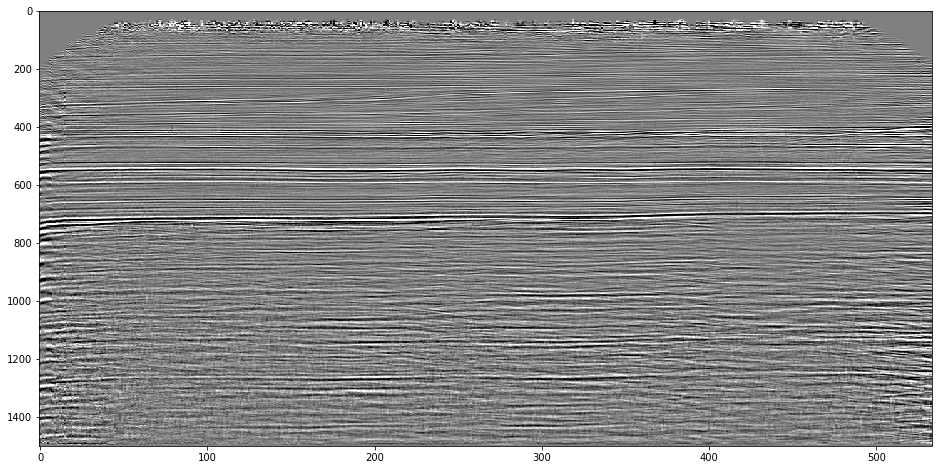

In [2]:
from seismic_handler import SeismicPrestack

handler = SeismicPrestack ('data/31_81_PR.sgy')
parts = handler.readGatherParts (10000, 10000)
data = parts[0]

handler.plot(data)

<module 'matplotlib.pyplot' from 'C:\\Users\\kostyad\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

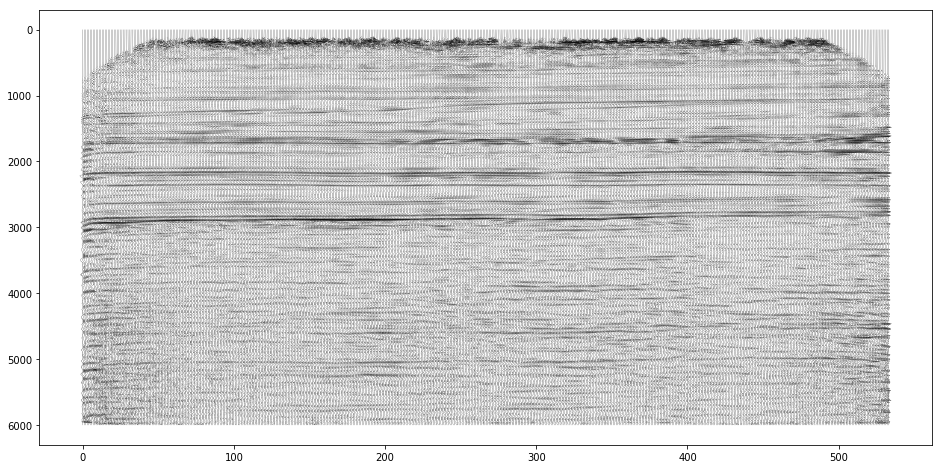

In [3]:
handler.wiggle_plot(data)

In [4]:
def addNoise (data):
    import numpy as np
    data_new = []
    for t in data:
        f = np.fft.rfft(t)
        l = len (f)
        llow = int(l*0.5);
        lhi = int(l*0.75)
        for i in range (l):
            
            if i < llow:
                sc = 0
            if i in range(llow, lhi):
                sc = (i - llow)/(lhi - llow)
            if i > lhi:
                sc = 1
            
            f [i] *= 1 + sc*100
        
        t_new = np.fft.irfft(f)
        data_new.append (t_new)
    return np.array(data_new)

<module 'matplotlib.pyplot' from 'C:\\Users\\kostyad\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

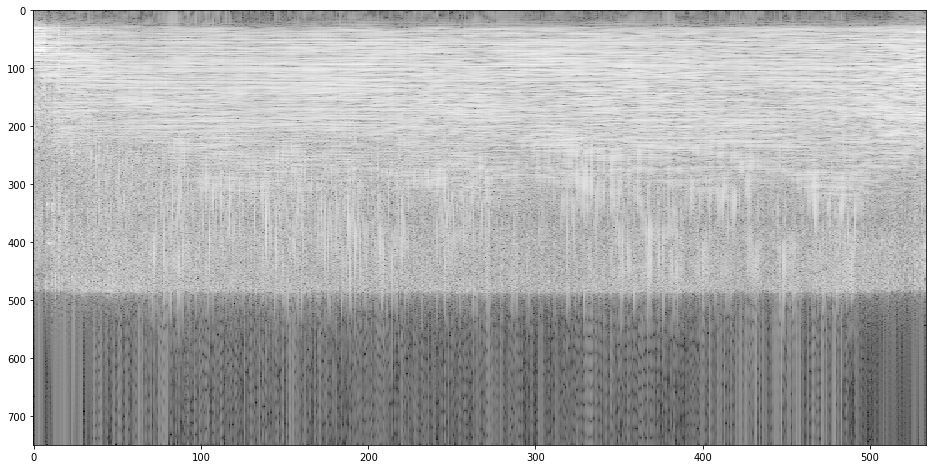

In [5]:
db_matrix = handler.spectrogram (data)
handler.plot_spec(db_matrix.T)

<module 'matplotlib.pyplot' from 'C:\\Users\\kostyad\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

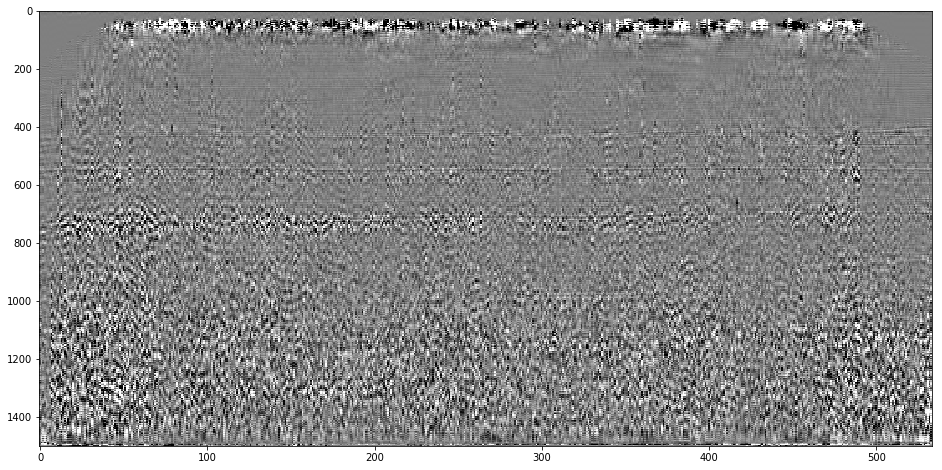

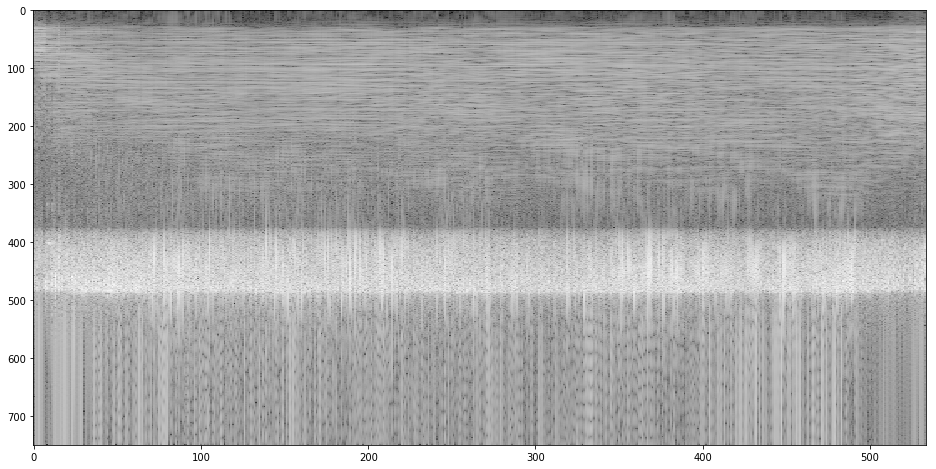

In [6]:
data_noise = addNoise(data)
handler.plot (data_noise)
db_matrix_noise = handler.spectrogram (data_noise)
handler.plot_spec(db_matrix_noise.T)

<module 'matplotlib.pyplot' from 'C:\\Users\\kostyad\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

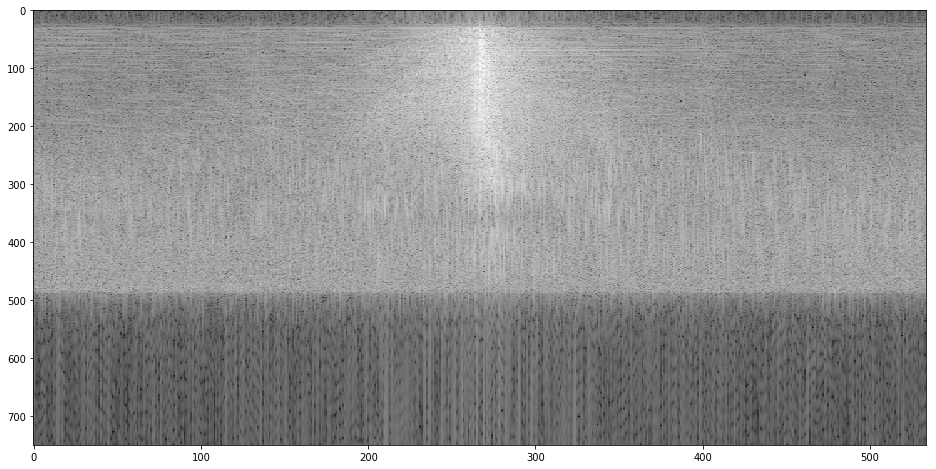

In [7]:
fk_spec = handler.fk (data)

handler.plot_spec(fk_spec)

prepare images

In [8]:
handler = SeismicPrestack ('data/31_81_PR.sgy')
parts = handler.readGatherParts (100, 0.2)

In [9]:
import os

images_dir = 'images/'

if os.path.exists(images_dir):
    import shutil
    shutil.rmtree(images_dir)

if not os.path.exists(images_dir):
    os.makedirs(images_dir)

train_data_dir = images_dir + 'train/'
validation_data_dir = images_dir + 'validation/'
    
if not os.path.exists(train_data_dir):
    os.makedirs(train_data_dir)

if not os.path.exists(validation_data_dir):
    os.makedirs(validation_data_dir)
    
image = SeismicPrestack.convert_to_image (parts[0].T)
image_size = image.size
image.save (images_dir + '/test.png')
    
counter = 0
nparts = len(parts)
for i in range(nparts):  
    if i < nparts*0.8:
        png_name = train_data_dir
    else:
        png_name = validation_data_dir

    data = parts[i]
    if i % 2 == 0:
        png_name += 'noise/'
        data = addNoise (data)
    else:
        png_name += 'norm/'
        
    if not os.path.exists(png_name):
        os.makedirs(png_name)
        
    png_name += str(counter) + '.png'
        
    image = SeismicPrestack.convert_to_image (data.T)
    
    image.save (png_name)
    
    counter = counter+1

TF

In [17]:
def train (train_data_dir, validation_data_dir, image_size):
    from keras import backend as K
    from keras.models import Sequential
    from keras.layers.core import Flatten, Dense, Dropout, Activation
    from keras.optimizers import rmsprop
    from keras.models import Sequential
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
    from keras.callbacks import EarlyStopping, ModelCheckpoint
    from keras.layers import Input, Dense
    import os
    import numpy as np
    import pandas as pd
    import numpy as np
    import pickle

    # Set values

    num_classes = 2
    nb_epoch = 5
    batch_size = 128

    nb_train_samples = sum([len(files) for r, d, files in os.walk(train_data_dir)])
    nb_validation_samples = sum([len(files) for r, d, files in os.walk(validation_data_dir)])
    
    
    print ('nb_train_samples', nb_train_samples)
    print ('nb_validation_samples', nb_validation_samples)
    
    if K.image_data_format() == 'channels_first':
        input_shape = (3, image_size[0], image_size[1])
    else:
        input_shape = (image_size[0], image_size[1], 3)

    # Specify model

    # callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)
    save_best_model = ModelCheckpoint(filepath='model_.{epoch:02d}_{val_loss:.2f}.hdf5', verbose=1,
            monitor='val_loss')

    # instantiate Sequential model
    model = Sequential()

    model.add(Conv2D(filters=64, kernel_size=2, strides=2, activation='elu', kernel_initializer='glorot_normal', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2, padding='same'))

    model.add(Conv2D(filters=128, kernel_size=2, strides=2, activation='elu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2, padding='same'))

    model.add(Conv2D(filters=256, kernel_size=2, strides=2, activation='elu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2, padding='same'))

    model.add(Conv2D(filters=512, kernel_size=2, strides=2, activation='elu', kernel_initializer='glorot_normal'))
    model.add(MaxPooling2D(pool_size=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(128))

    model.add(Activation('elu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    opt = rmsprop()

    model.compile(loss='categorical_crossentropy',
                 optimizer = opt,
                 metrics = ['accuracy'])

    # Image generators
    train_datagen = ImageDataGenerator(rescale= 1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=image_size,
        shuffle=True,
        batch_size=batch_size,
        class_mode='categorical'
        )

    validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=image_size,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical'
        )

    # Fit model
    history = model.fit_generator(train_generator,
                        steps_per_epoch=(nb_train_samples // batch_size) +1,
                        epochs=nb_epoch,
                        validation_data=validation_generator,
                        callbacks=[early_stopping, save_best_model],
                        validation_steps=(nb_validation_samples // batch_size)+1
                       )

    # Save model
    model.save_weights('full_model_weights.h5')
    model.save('model.h5')

In [60]:
def test (validation_data_dir, image_size):
    from keras.models import load_model
    import glob
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
    
    # Load model
    model = load_model('model.h5')

    # Predict against saved spectrograms
    spect_files = glob.glob(validation_data_dir + "*.png")
    print ('test files', len (spect_files))

    images = []
    for file in spect_files:
        img = load_img('{}'.format(file), target_size=image_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255
        images.append(img_array)

    print('Analyzing file...')

    predictions = []
    for image in images:
        prediction = model.predict(image)
        predictions.append(prediction)

    #print ('predictions', [a[0] for a in predictions])
    
    # Sum individual probabilities for all spectrograms
    pred_sum = sum(a[0] for a in predictions)
    print (pred_sum)
    biggest_num = np.amax(pred_sum)
    pct_confidence = round((biggest_num / sum(pred_sum) * 100), 2)
    pred_class_num = np.argmax(pred_sum)

    print('\nPrediction = {}, with {}% confidence.'.format(pred_class_num, pct_confidence))

In [61]:
#train (train_data_dir, validation_data_dir, image_size)
#test (validation_data_dir + 'noise/', image_size)

In [62]:
def mn (X_train, y_train, X_test, y_test):
    from keras.models import Model # basic class for specifying and training a neural network
    from keras.layers import Input, Dense # the two types of neural network layer we will be using
    from keras.utils import np_utils # utilities for one-hot encoding of ground truth values

    batch_size = 128 # in each iteration, we consider 128 training examples at once
    num_epochs = 20 # we iterate twenty times over the entire training set
    hidden_size = 512 # there will be 512 neurons in both hidden layers

    num_train = X_train.shape[0] # there are 60000 training examples in MNIST
    num_test = X_test.shape[0] # there are 10000 test examples in MNIST

    height = X_test[0].shape[0]
    width = X_test[0].shape[1]
    
    #height, width, depth = 28, 28, 1 # MNIST images are 28x28 and greyscale
    num_classes = len(np.unique(y_train)) # there are 10 classes (1 per digit)

    X_train = X_train.reshape(num_train, height * width) # Flatten data to 1D
    X_test = X_test.reshape(num_test, height * width) # Flatten data to 1D
    X_train = X_train.astype('float32') 
    X_test = X_test.astype('float32')
    X_train /= 255 # Normalise data to [0, 1] range
    X_test /= 255 # Normalise data to [0, 1] range

    Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
    Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels

    inp = Input(shape=(height * width,)) # Our input is a 1D vector of size 784
    hidden_1 = Dense(hidden_size, activation='relu')(inp) # First hidden ReLU layer
    hidden_2 = Dense(hidden_size, activation='relu')(hidden_1) # Second hidden ReLU layer
    out = Dense(num_classes, activation='softmax')(hidden_2) # Output softmax layer

    model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

    model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
                  optimizer='adam', # using the Adam optimiser
                  metrics=['accuracy']) # reporting the accuracy

    model.fit(X_train, Y_train, # Train the model using the training set...
              batch_size=batch_size, nb_epoch=num_epochs,
              verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation
    model.evaluate(X_test, Y_test, verbose=1) # Evaluate the trained model on the test set!

In [63]:
from keras.datasets import mnist # subroutines for fetching the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data

mn (X_train, y_train, X_test, y_test)

C:\Users\kostyad\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
C:\Users\kostyad\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 12s - loss: 0.2345 - acc: 0.9304 - val_loss: 0.1083 - val_acc: 0.9677
Epoch 2/20
54000/54000 [==============================] - 12s - loss: 0.0840 - acc: 0.9747 - val_loss: 0.0729 - val_acc: 0.9767
Epoch 3/20
54000/54000 [==============================] - 12s - loss: 0.0542 - acc: 0.9830 - val_loss: 0.0748 - val_acc: 0.9772
Epoch 4/20
54000/54000 [==============================] - 11s - loss: 0.0363 - acc: 0.9886 - val_loss: 0.0735 - val_acc: 0.9807
Epoch 5/20
54000/54000 [==============================] - 12s - loss: 0.0268 - acc: 0.9911 - val_loss: 0.0868 - val_acc: 0.9762
Epoch 6/20
54000/54000 [==============================] - 12s - loss: 0.0242 - acc: 0.9920 - val_loss: 0.0733 - val_acc: 0.9818
Epoch 7/20
54000/54000 [==============================] - 12s - loss: 0.0200 - acc: 0.9936 - val_loss: 0.0776 - val_acc: 0.9807
Epoch 8/20
54000/54000 [==============================]

In [41]:
def ci (X_train, y_train, X_test, y_test):
    from keras.models import Model # basic class for specifying and training a neural network
    from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
    from keras.utils import np_utils # utilities for one-hot encoding of ground truth values
    import numpy as np


    batch_size = 32 # in each iteration, we consider 32 training examples at once
    num_epochs = 200 # we iterate 200 times over the entire training set
    kernel_size = 3 # we will use 3x3 kernels throughout
    pool_size = 2 # we will use 2x2 pooling throughout
    conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
    conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
    drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
    drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
    hidden_size = 512 # the FC layer will have 512 neurons

    num_train, depth, height, width = X_train.shape # there are 50000 training examples in CIFAR-10 
    num_test = X_test.shape[0] # there are 10000 test examples in CIFAR-10
    num_classes = np.unique(y_train).shape[0] # there are 10 image classes

    X_train = X_train.astype('float32') 
    X_test = X_test.astype('float32')
    X_train /= np.max(X_train) # Normalise data to [0, 1] range
    X_test /= np.max(X_train) # Normalise data to [0, 1] range

    Y_train = np_utils.to_categorical(y_train, num_classes) # One-hot encode the labels
    Y_test = np_utils.to_categorical(y_test, num_classes) # One-hot encode the labels


    inp = Input(shape=(depth, height, width)) # N.B. depth goes first in Keras!
    # Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
    conv_1 = Convolution2D(conv_depth_1, kernel_size, kernel_size, border_mode='same', activation='relu')(inp)
    conv_2 = Convolution2D(conv_depth_1, kernel_size, kernel_size, border_mode='same', activation='relu')(conv_1)
    pool_1 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_2)
    drop_1 = Dropout(drop_prob_1)(pool_1)
    # Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
    conv_3 = Convolution2D(conv_depth_2, kernel_size, kernel_size, border_mode='same', activation='relu')(drop_1)
    conv_4 = Convolution2D(conv_depth_2, kernel_size, kernel_size, border_mode='same', activation='relu')(conv_3)
    pool_2 = MaxPooling2D(pool_size=(pool_size, pool_size))(conv_4)
    drop_2 = Dropout(drop_prob_1)(pool_2)
    # Now flatten to 1D, apply FC -> ReLU (with dropout) -> softmax
    flat = Flatten()(drop_2)
    hidden = Dense(hidden_size, activation='relu')(flat)
    drop_3 = Dropout(drop_prob_2)(hidden)
    out = Dense(num_classes, activation='softmax')(drop_3)

    model = Model(input=inp, output=out) # To define a model, just specify its input and output layers

    model.compile(loss='categorical_crossentropy', # using the cross-entropy loss function
                  optimizer='adam', # using the Adam optimiser
                  metrics=['accuracy']) # reporting the accuracy

    model.fit(X_train, Y_train, # Train the model using the training set...
              batch_size=batch_size, nb_epoch=num_epochs,
              verbose=1, validation_split=0.1) # ...holding out 10% of the data for validation
    model.evaluate(X_test, Y_test, verbose=1) # Evaluate the trained model on the test set!


In [65]:
from keras.datasets import cifar10 # subroutines for fetching the CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data() # fetch CIFAR-10 data

ci (X_train, y_train, X_test, y_test)

C:\Users\kostyad\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
C:\Users\kostyad\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
C:\Users\kostyad\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
C:\Users\kostyad\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
C:\Users\kostyad\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:48: UserWarning: Update your `Model` call to the Keras 2 API: `Model(

Train on 45000 samples, validate on 5000 samples
Epoch 1/200
27424/45000 [=================>............] - ETA: 183s - loss: 1.6734 - acc: 0.3840

KeyboardInterrupt: 

In [58]:
def seis_dataset ():
    handler = SeismicPrestack ('data/31_81_PR.sgy')
    parts = handler.readGatherParts (50, 0.1)
    
    from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

    X_train = []
    y_train = []
    X_test = [] 
    y_test = []
    
    counter = 0
    nparts = len(parts)
    sh = parts[0].shape
    for i in range(nparts): 
        data = parts[i]
        if data.shape != sh:
            #print ('shape error')
            continue
            
        category = 0
        if i % 2 == 0:
            data = addNoise (data)
            category = 1
        
        image = SeismicPrestack.convert_to_image (data.T, (64,64))
        data = img_to_array (image)
        
#        image = array_to_img (data)
#        png_name = 'images/' + str(counter) + '.png'
#        image.save (png_name)
        
        if i < nparts*0.8:
            X_train.append(data)
            y_train.append (category)
        else:
            X_test.append(data)
            y_test.append(category)   
        counter = counter+1
    
    y_test = np.array(y_test)
    y_train = np.array(y_train)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    
    
    if len(X_train) != len(y_train):
        print ('len(X_train) != len(y_train)')
        return
    if len(X_test) != len(y_test):
        print ('len(X_test) != len(y_test)')
        return

    return (X_train, y_train), (X_test, y_test)

In [59]:

(X_train, y_train), (X_test, y_test) = seis_dataset ()

mn (X_train, y_train, X_test, y_test)

C:\Users\kostyad\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
C:\Users\kostyad\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1670 samples, validate on 186 samples
Epoch 1/20
1670/1670 [==============================] - 1s - loss: 2.0006 - acc: 0.4892 - val_loss: 1.9005 - val_acc: 0.4946
Epoch 2/20
1670/1670 [==============================] - 1s - loss: 1.0460 - acc: 0.5018 - val_loss: 0.7657 - val_acc: 0.5000
Epoch 3/20
1670/1670 [==============================] - 1s - loss: 0.7257 - acc: 0.4820 - val_loss: 0.7719 - val_acc: 0.5000
Epoch 4/20
1670/1670 [==============================] - 1s - loss: 0.7503 - acc: 0.4988 - val_loss: 0.7155 - val_acc: 0.4946
Epoch 5/20
1670/1670 [==============================] - 1s - loss: 0.6933 - acc: 0.5186 - val_loss: 0.6917 - val_acc: 0.4892
Epoch 6/20
1670/1670 [==============================] - 1s - loss: 0.6888 - acc: 0.5389 - val_loss: 0.6875 - val_acc: 0.5806
Epoch 7/20
1670/1670 [==============================] - 1s - loss: 0.6922 - acc: 0.5054 - val_loss: 0.7127 - val_acc: 0.5000
Epoch 8/20
1670/1670 [==============================] - 1s - loss: 0.6984 - ac